In [1]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier  # Changed to RandomForest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import matplotlib.pyplot as plt

# Load your PCA-transformed data
x_train = np.load('x_train_pca95.npy')  # Or however you named it
x_val = np.load('x_val_pca95.npy')
x_test = np.load('x_test_pca95.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')
y_test = np.load('y_test.npy')

Training and Evaluation Function

In [2]:
def train_and_evaluate_rf(x_train, y_train, x_val, y_val, x_test, y_test,
                         max_depth=None, min_samples_split=2):
    """Trains and evaluates a Random Forest model."""

    start_time = time.time()
    model = RandomForestClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42  # For reproducibility
    )
    model.fit(x_train, y_train)
    training_time = time.time() - start_time

    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Validation Accuracy (Random Forest doesn't directly give 'loss' like Logistic Regression)
    y_val_pred = model.predict(x_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    return model, training_time, accuracy, val_accuracy

 Base Model Training

In [3]:
# --- Base Model Training ---
print("--- Base Random Forest Model ---")

rf_model, rf_time, rf_acc, rf_val_acc = train_and_evaluate_rf(
    x_train, y_train, x_val, y_val, x_test, y_test,
    max_depth=20, min_samples_split=5  # Example values
)

print("Test Accuracy:", rf_acc)
print("Validation Accuracy:", rf_val_acc)
print("Training Time:", rf_time)

--- Base Random Forest Model ---
Test Accuracy: 0.862
Validation Accuracy: 0.8603123214625785
Training Time: 231.5366108417511


Hyperparameter Tuning (GridSearchCV)

In [4]:
# --- Hyperparameter Tuning ---
print("\n--- Random Forest Hyperparameter Tuning ---")

param_grid_rf = {
    'max_depth': [10, 20, 30, None],  # None means no maximum depth
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),  # Keep random_state for reproducibility
    param_grid_rf,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1  # Use all available cores
)

grid_search_rf.fit(x_train, y_train)

best_rf_model = grid_search_rf.best_estimator_
print("Best Parameters:", grid_search_rf.best_params_)

y_pred_best_rf = best_rf_model.predict(x_test)
best_rf_test_acc = accuracy_score(y_test, y_pred_best_rf)
print("Best Model Test Accuracy:", best_rf_test_acc)


--- Random Forest Hyperparameter Tuning ---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'max_depth': 30, 'min_samples_split': 2}
Best Model Test Accuracy: 0.8609523809523809


Overfitting Analysis

In [5]:
# --- Overfitting Analysis ---
print("\n--- Overfitting Analysis ---")

y_train_pred = best_rf_model.predict(x_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = best_rf_test_acc  # From GridSearchCV

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Overfitting Gap:", train_accuracy - test_accuracy)

# Classification Report and Confusion Matrix (Optional but good to have)
print("\nClassification Report:\n", classification_report(y_test, y_pred_best_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best_rf))


--- Overfitting Analysis ---
Training Accuracy: 0.9999795910037145
Test Accuracy: 0.8609523809523809
Overfitting Gap: 0.13902721005133356

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.86      0.82      1040
           1       1.00      0.95      0.97      1061
           2       0.77      0.80      0.79      1036
           3       0.86      0.89      0.88      1103
           4       0.76      0.81      0.79       995
           5       0.92      0.93      0.93      1075
           6       0.72      0.55      0.63      1083
           7       0.93      0.90      0.92      1032
           8       0.93      0.96      0.94       993
           9       0.92      0.94      0.93      1082

    accuracy                           0.86     10500
   macro avg       0.86      0.86      0.86     10500
weighted avg       0.86      0.86      0.86     10500


Confusion Matrix:
 [[ 895    0   13   48    6    3   62    0   13    0]
 [  

Validation "Curve" (Approximation with GridSearchCV)


--- Validation Curve Approximation ---


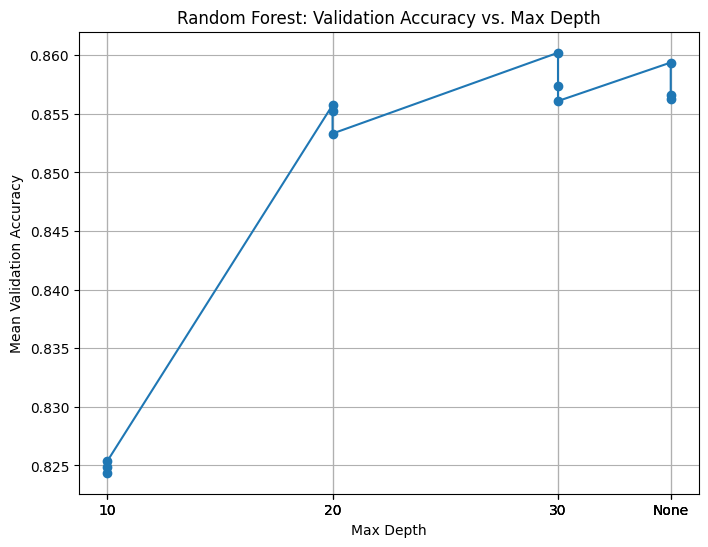

In [7]:
# --- Validation "Curve" Approximation ---
print("\n--- Validation Curve Approximation ---")

#  We'll plot performance vs. max_depth (you could adapt for min_samples_split)

mean_val_scores = grid_search_rf.cv_results_['mean_test_score']
max_depths = grid_search_rf.cv_results_['param_max_depth']  # Corrected line

#  For plotting, we need to handle 'None' in max_depth
max_depths_for_plot = [d if d is not None else max(
    [val for val in max_depths if val is not None]) + 5 for d in max_depths]  # Replace None with a large value

plt.figure(figsize=(8, 6))
plt.plot(max_depths_for_plot, mean_val_scores, marker='o')
plt.xticks(max_depths_for_plot,
           [str(d) for d in max_depths])  # Ensure 'None' is labeled correctly
plt.xlabel("Max Depth")
plt.ylabel("Mean Validation Accuracy")
plt.title("Random Forest: Validation Accuracy vs. Max Depth")
plt.grid(True)
plt.show()